# Grundlegende Eigenschaften von qubits

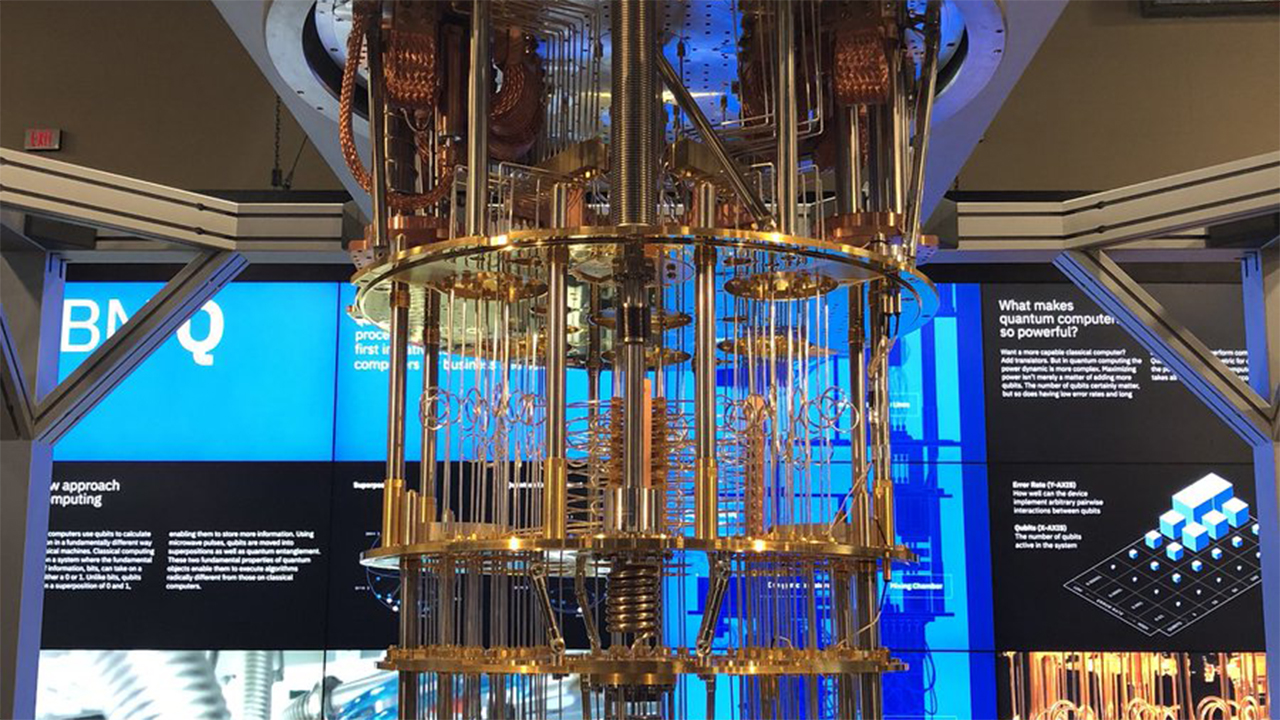

In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram

## Physik und Quantum Supremacy

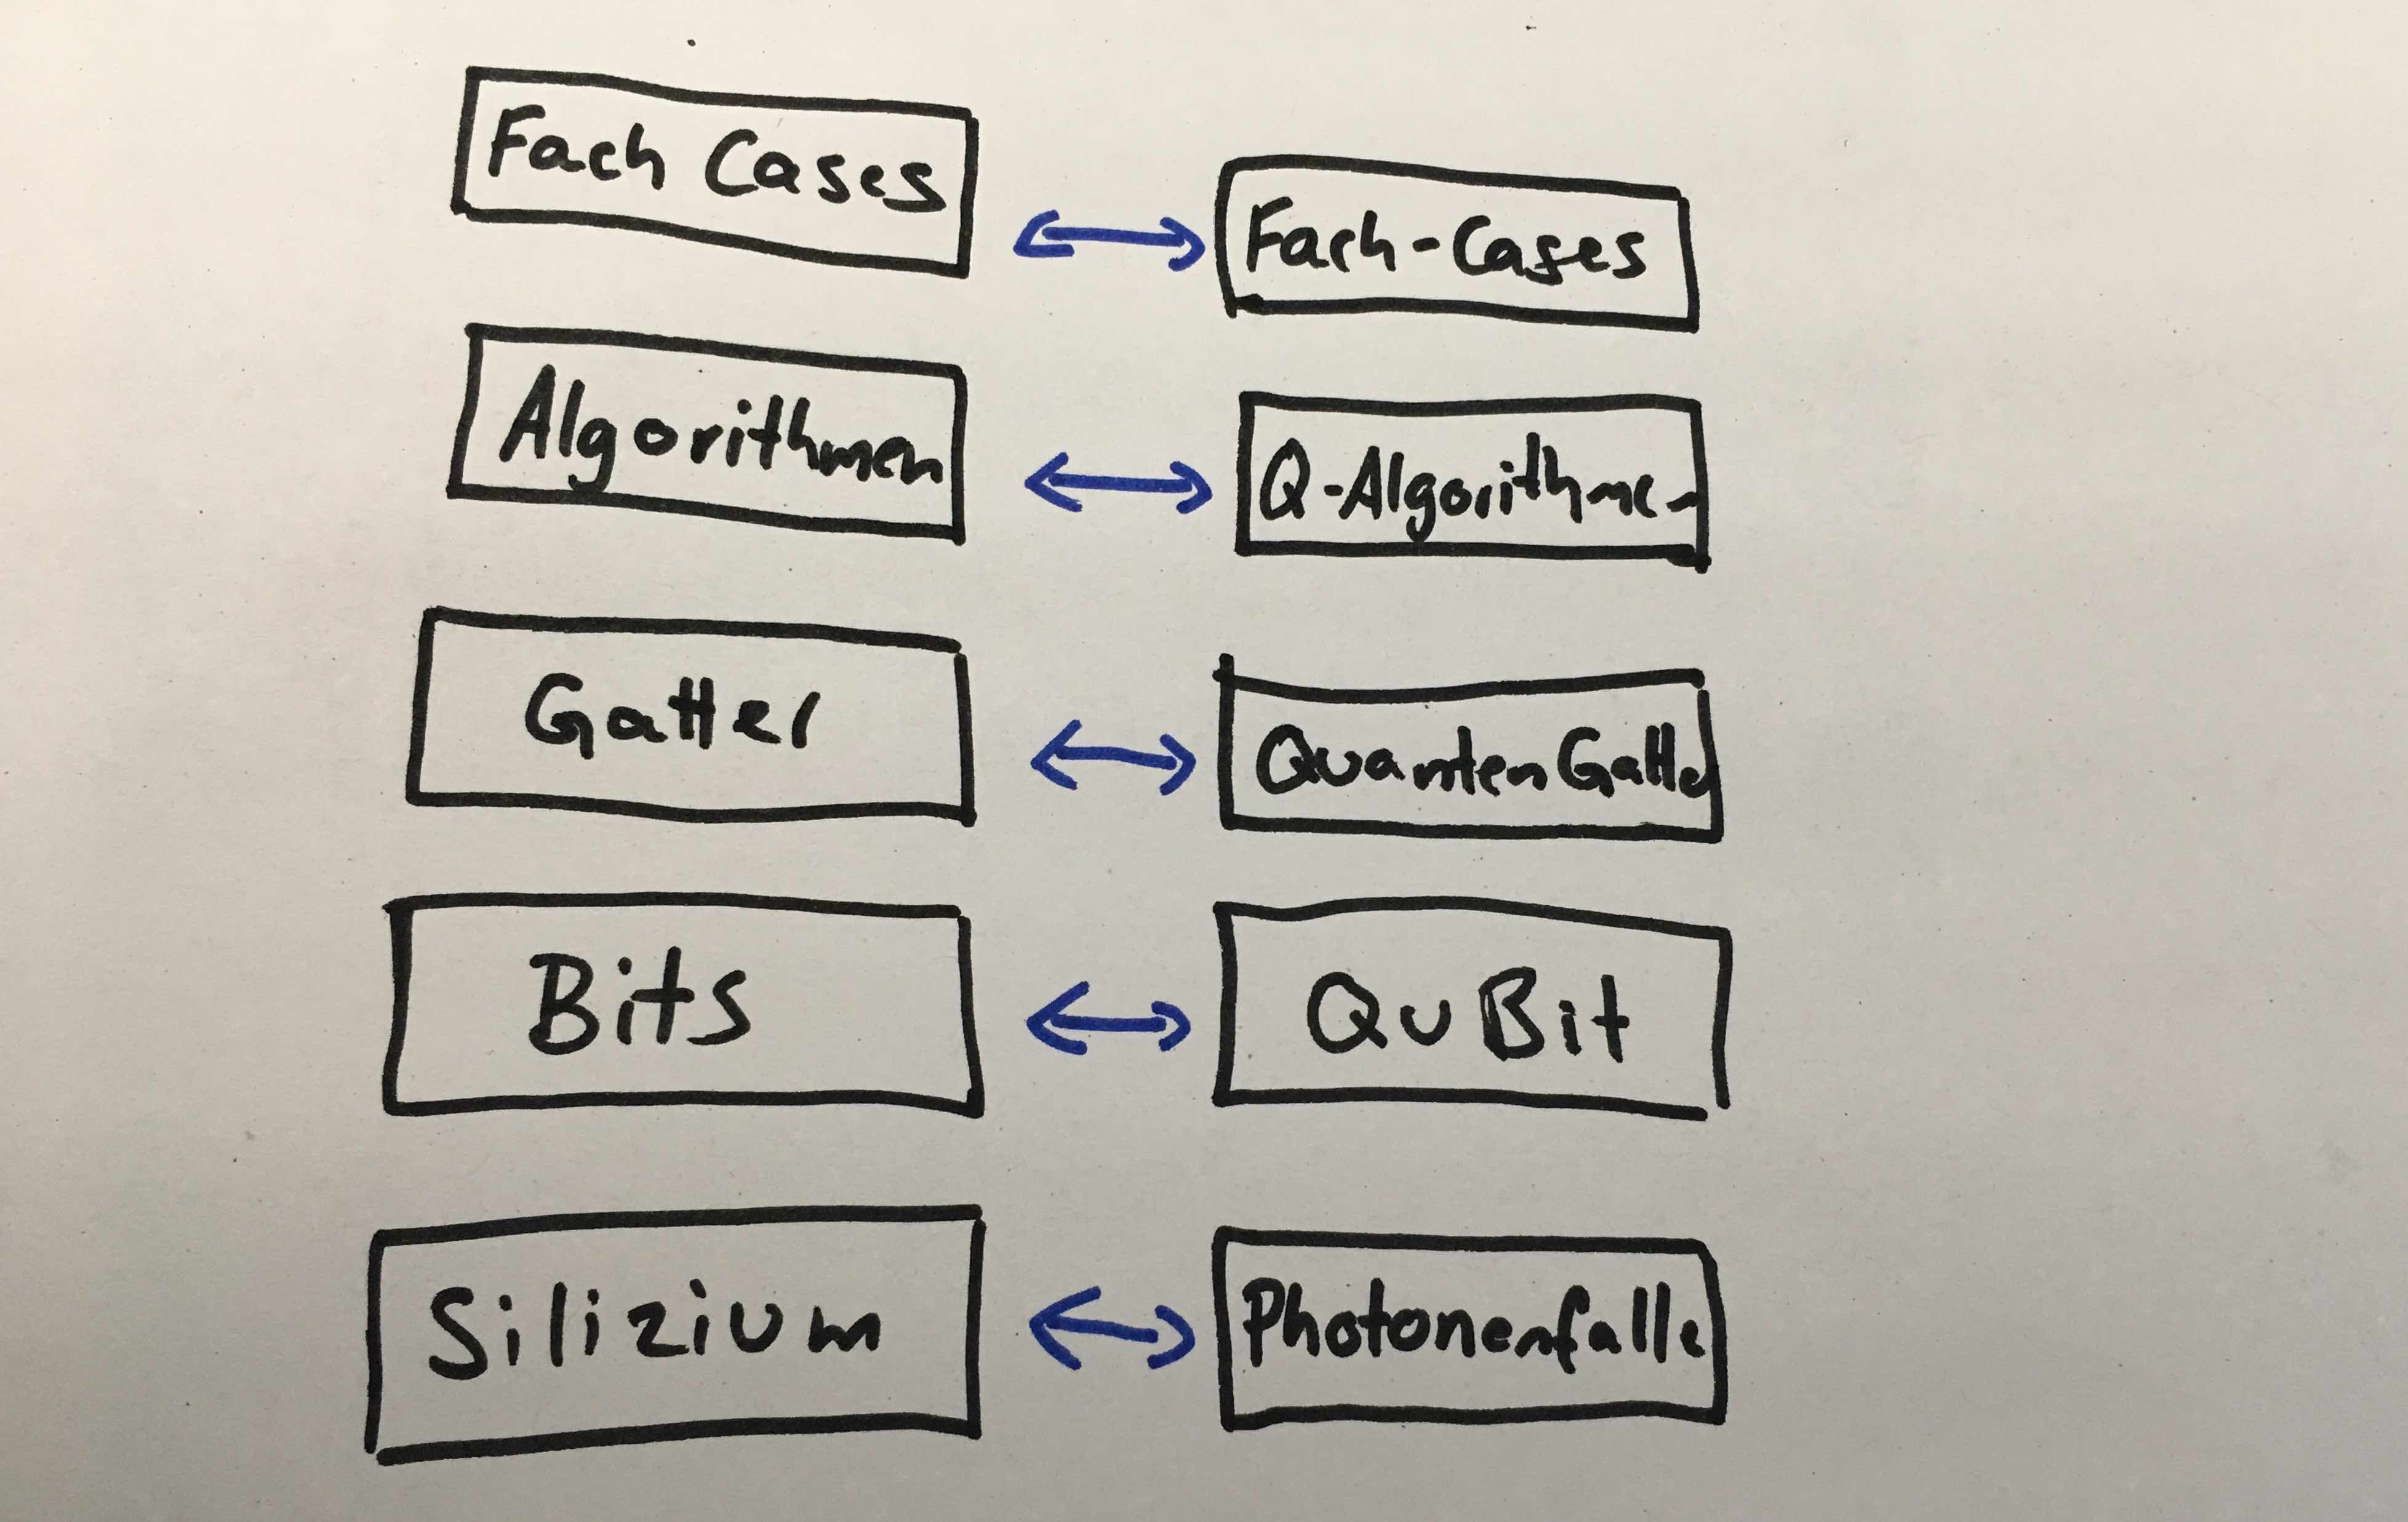

## Eine einfache Messung, welche ein Qubit auf ein klassisches Bit misst

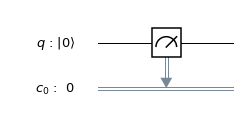

In [2]:
measure_z = QuantumCircuit(1,1)
measure_z.measure(0,0) #misst den qubit 0 auf den bit 0
measure_z.draw(output='mpl')

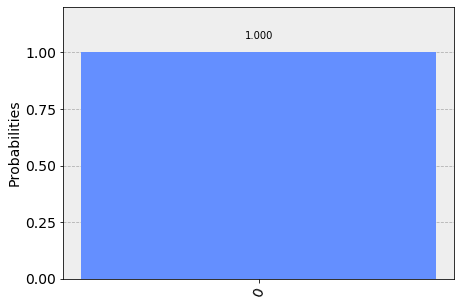

In [3]:
qc_0 = QuantumCircuit(1)
qc = qc_0 + measure_z
counts = execute(qc, Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(counts)


## Jetzt machen wir eine x Messung, statt z

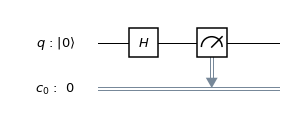

In [4]:
measure_x = QuantumCircuit(1,1)
measure_x.h(0) #Hadamard gate bewegt die z-Achse zur x-Achse und umgekehrt
#measure_x.h(0) #Hadamard gate
measure_x.measure(0,0) #misst den qubit 0 auf den bit 0
measure_x.draw(output='mpl')

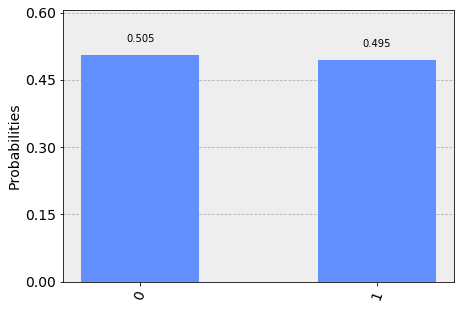

In [5]:
qc_0 = QuantumCircuit(1)
qc = qc_0 + measure_x
counts = execute(qc, Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(counts)

## Man kann auch beliebige Gates einfügen

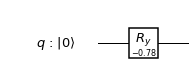

In [6]:
qc_y = QuantumCircuit(1)
qc_y.ry(-3.14/4,0)
qc_y.draw(output='mpl')

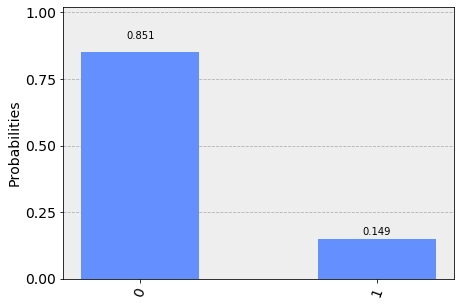

In [7]:
qc = qc_y + measure_z
counts = execute(qc, Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(counts)

In [8]:
from qiskit.visualization import plot_bloch_vector

## Die Bloch Sphere
Jeder qubit state kann als ein Punkt auf der Bloch-Sphere beschrieben werden.

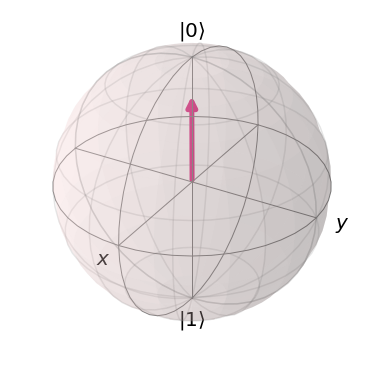

In [9]:
# z measurement of qubit 0
measure_z = QuantumCircuit(1,1)
measure_z.measure(0,0);

# x measurement of qubit 0
measure_x = QuantumCircuit(1,1)
measure_x.h(0)
measure_x.measure(0,0)

# y measurement of qubit 0
measure_y = QuantumCircuit(1,1)
measure_y.sdg(0)
measure_y.h(0)
measure_y.measure(0,0);

shots = 2**18 # number of samples used for statistics

bloch_vector = []
for measure_circuit in [measure_x, measure_y, measure_z]:
    
    # run the circuit with a the selected measurement and get the number of samples that output each bit value
    counts = execute(qc+measure_circuit,Aer.get_backend('qasm_simulator'),shots=shots).result().get_counts()

    # calculate the probabilities for each bit value
    probs = {}
    for output in ['0','1']:
        if output in counts:
            probs[output] = counts[output]/shots
        else:
            probs[output] = 0
            
    bloch_vector.append( probs['0'] -  probs['1'] )
    
plot_bloch_vector( bloch_vector )

# Verschränkung / Entanglement

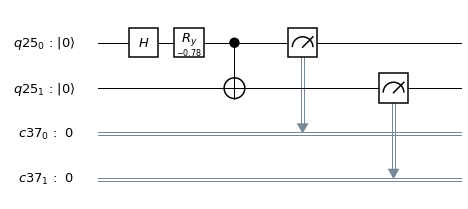

In [52]:
# Creating registers
q = QuantumRegister(2)
c = ClassicalRegister(2)

# quantum circuit to make an entangled bell state 
bell = QuantumCircuit(q, c)
bell.h(q[0])
bell.ry(-3.14/4,0) #do some tilt
bell.cx(q[0], q[1])
bell.measure(q[0], c[0])
bell.measure(q[1], c[1])

bell.draw(output='mpl')


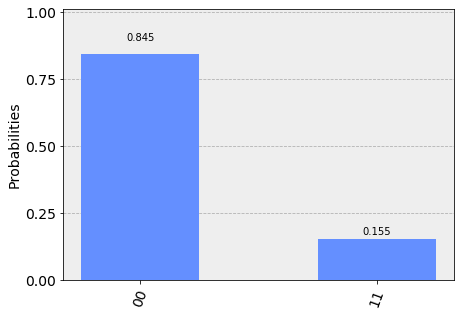

In [53]:
counts = execute(bell, Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(counts)

# Ein Algorithmus: Quantum Teleportation

In [11]:
# simple function that applies a series of unitary gates from a given string
def apply_secret_unitary(secret_unitary, qubit, quantum_circuit, dagger):
    functionmap = {
                    'x':quantum_circuit.x,
                    'y':quantum_circuit.y,
                    'z':quantum_circuit.z,
                    'h':quantum_circuit.h,                    
                    't':quantum_circuit.t,                    
    }
    if dagger: functionmap['t'] = quantum_circuit.tdg
    
    if dagger:
        [functionmap[unitary](qubit) for unitary in secret_unitary]
    else:
        [functionmap[unitary](qubit) for unitary in secret_unitary[::-1]]


In [12]:
secret_unitary = 'x'

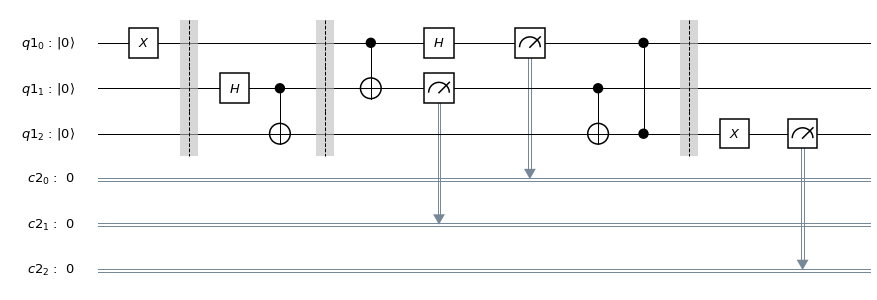

In [13]:
# Create the quantum circuit
q = QuantumRegister(3)
c = ClassicalRegister(3)
qc = QuantumCircuit(q, c)

''' Qubit ordering as follows (classical registers will just contain measured values of the corresponding qubits):
q[0]: qubit to be teleported (Alice's first qubit. It was given to her after the application of a secret unitary 
      which she doesn't know)
q[1]: Alice's second qubit
q[2]: Bob's qubit, which will be the destination for the teleportation
'''

# Apply the secret unitary that we are using to generate the state to teleport. You can change it to any unitary
apply_secret_unitary(secret_unitary, q[0], qc, dagger = 0)
qc.barrier()
# Next, generate the entangled pair between Alice and Bob (Remember: Hadamard followed by CX generates a Bell pair)
qc.h(q[1])
qc.cx(q[1], q[2])
qc.barrier()
# Next, apply the teleportation protocol. 
qc.cx(q[0], q[1])
qc.h(q[0])
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])
qc.cx(q[1], q[2])
qc.cz(q[0], q[2])
qc.barrier()

'''
In principle, if the teleportation protocol worked, we have q[2] = secret_unitary|0>
As a result, we should be able to recover q[2] = |0> by applying the reverse of secret_unitary
since for a unitary u, u^dagger u = I.
'''
apply_secret_unitary(secret_unitary, q[2], qc, dagger=1)
qc.measure(q[2], c[2])
qc.draw(output='mpl')

{'011': 258, '000': 251, '001': 270, '010': 245}


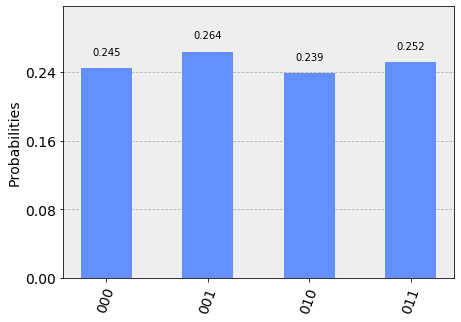

In [14]:
backend = Aer.get_backend('qasm_simulator')
job_sim = execute(qc, backend, shots=1024)
sim_result = job_sim.result()

measurement_result = sim_result.get_counts(qc)
print(measurement_result)
plot_histogram(measurement_result)

# Ein Algorithmus: Optimierung einer Fehlerfunktion

# Fachliches Beispiel